<a href="https://colab.research.google.com/github/KeesStuij/VariableElimination/blob/main/Kopie_van_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weekly assignment 4

## Read before you start

* Provide clear and complete answers in code blocks or markdown. You may add as many as you need.
* Always motivate your answers. This can be done in markdown cells, or in comments in code.
* Submit your results via Brightspace. Use the following filename convention: ``StudentName1_snumber1_StudentName2_snumber2_Assignment4.ipynb``.
* Make sure you submit a fully executed version of the notebook file. The teaching assistants will not run/debug your code during grading.
* Questions? Ask them during the workgroups, or see Brightspace for instructions on how to proceed.

## Starting with JAGS

This is the first assignment that uses the probabilistic programming language JAGS (Just Another Gibbs Sampler). JAGS automatically derives MCMC steps for us, so we do not have to write our own sampling algorithms every time we change a model or make a new one.

JAGS interfaces with many other programming languages, such as R, Matlab and Python. Unfortunately, the interface `pyjags` does not work under Windows, so if you are a Windows user it is easiest to use e.g. Google Colab. The code below installs JAGS and the PyJAGS interface:

In [ ]:
!apt install jags
!pip install pyjags

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
jags is already the newest version (4.3.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyjags as pj

plt.rc('font', size=14)         # default fontsize
plt.rc('axes', titlesize=16)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=16)   # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

Let us start with a simple coin flip example to see if we can get JAGS to do what we want it to.

Recall our beta-Bernoulli model:

$$
\begin{align}
    \theta &\sim \mathrm{beta}(a, b) \\
    x_i & \sim \mathrm{Bernoulli}(\theta), \qquad i=1,\ldots,N.
\end{align}
$$

The code block below manually selects the 'true' value for $\theta$, and then randomly generates $N=20$ coin flip outcomes $x_i$ using this value. We will use Bayesian inference to learn the posterior $p(\theta\mid x_1, \ldots, x_N, a, b)$.

In [ ]:
theta = 0.7
N = 20
x = np.random.binomial(n=1, p=theta, size=N)
print(*x)

1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1


1. Now it is up to you to define the JAGS model. This is simply a text file or a string, as you can see below. Use the material in the lecture slides and the JAGS manual to implement the beta-Bernoulli model.

In [ ]:
jags_model_text = '''
model {
    # prior
    theta ~ dbeta(a, b)

    # likelihood
    for (i in 1:N) {
      x[i] ~ dbern(theta)
    }
}
'''

JAGS expects a Python dictionary as input. This should contain all values that are needed, as JAGS cannot 'see' outside of its model definition; for example, it doesn't know what $N$ is, or $a$ and $b$, unless we tell it explicitly here:

In [ ]:
# a=b=1 specifies a uniform prior
a = 1
b = 1

data = dict(x=x, N=N, a=a, b=b)

We then need to tell JAGS how many iterations to run the MCMC algorithm for, and how many chains it should run. A reasonable default is below.

In [ ]:
# How long we sample
num_iter = 100_000
# How many parallel sampling runs
num_chains = 4

Next, we tell JAGS to compile the Bayesian model from the text and to actually do the sampling. We specifically must instruct JAGS which variables it actually should keep track of (for some larger models, we might ignore certain variables to save memory).

Note 1: JAGS automatically selects initial values for each of the variables in each of the chains.

Note 2: for convenience I've added the `%%time` command, to show how long the sampling takes (and to know when it is done). You'll see it is very fast. For large models, sampling can take much longer!

In [ ]:
%%time
model = pj.Model(jags_model_text, data=data, chains=num_chains)
samples = model.sample(num_iter, vars=['theta'])

sampling: iterations 400000 of 400000, elapsed 0:00:00, remaining 0:00:00
CPU times: user 259 ms, sys: 6.89 ms, total: 266 ms
Wall time: 307 ms


Now that JAGS has collected samples, we have an approximate posterior distribution of $\theta$. In fact, we have `num_chains` of these.

2. Make a plot in which you show histograms of the approximate distributions _for each chain_. That is, if we have 4 chains, the figure should show 4 histograms of different colors. If the sampler has _converged_, these histograms should all be very similar and will overlap strongly; so for visualization it helps to set `alpha=0.2` in `plt.hist`.

Tip: we want to see the approximated posterior probability density $p(\theta\mid z, N, a, b)$. By setting `density=True` in `plt.hist`, the histogram is not showing counts (how many samples per bin), but density.

Don't forget proper labeling of your axes.

(1, 100000, 4)
[[[0.74814978 0.6814275  0.65235201 0.8448786 ]
  [0.72358502 0.81444985 0.67087521 0.62512927]
  [0.66792358 0.68748881 0.80993359 0.66989984]
  ...
  [0.68095811 0.73033625 0.73310966 0.59841052]
  [0.63619815 0.68574262 0.67860442 0.55199009]
  [0.73688605 0.78566946 0.54095914 0.67266548]]]


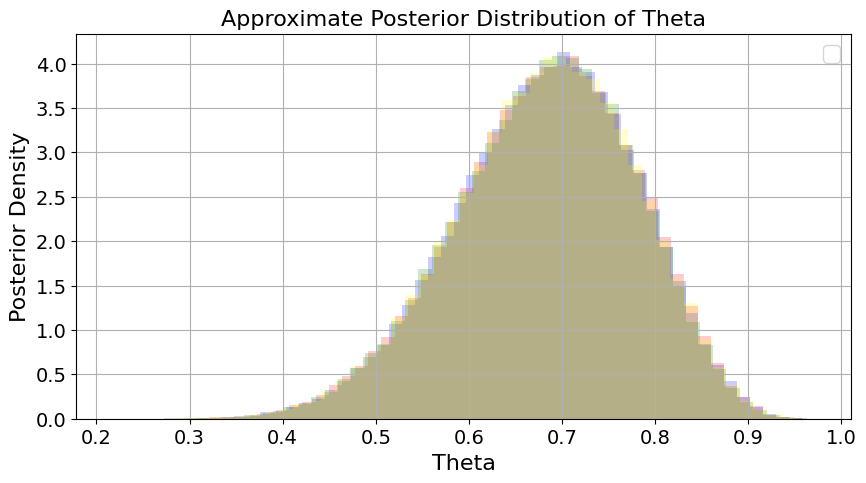

In [ ]:
plt.figure(figsize=(10, 5))

theta_samples = samples['theta']

print(theta_samples.shape)
print(theta_samples)
colors = ['red', 'blue', 'green', 'yellow']
for i in range(num_chains):
  plt.hist(theta_samples[0,:,i], bins=50, density=True, alpha=0.2, color=colors[i])

plt.xlabel('Theta')
plt.ylabel('Posterior Density')
plt.title('Approximate Posterior Distribution of Theta')
plt.legend()
plt.grid(True)
plt.show()
plt.show()

If we agree the histograms look very similar (if they do not, something is wrong! You can simulate this case by setting `num_iterations` to a low value, e.g. 50, and running your analysis again. Because you have drawn too few samples, the histograms are clearly distinct), then we no longer need to keep the chains separate. By merging the chains, we now have more samples, and thus a better approximation.

3. Make a new figure with a normalized (= `density=True`) histogram that uses all our samples, and plot a vertical line at our true value for $\theta$.

(1, 100000, 4)
[[[0.74814978 0.6814275  0.65235201 0.8448786 ]
  [0.72358502 0.81444985 0.67087521 0.62512927]
  [0.66792358 0.68748881 0.80993359 0.66989984]
  ...
  [0.68095811 0.73033625 0.73310966 0.59841052]
  [0.63619815 0.68574262 0.67860442 0.55199009]
  [0.73688605 0.78566946 0.54095914 0.67266548]]]


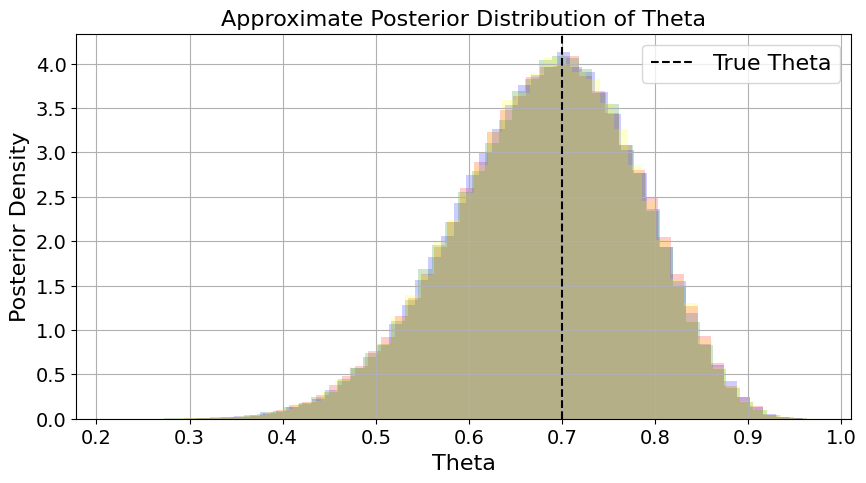

In [ ]:
plt.figure(figsize=(10, 5))

theta_samples = samples['theta']

print(theta_samples.shape)
print(theta_samples)
colors = ['red', 'blue', 'green', 'yellow']
for i in range(num_chains):
  plt.hist(theta_samples[0,:,i], bins=50, density=True, alpha=0.2, color=colors[i])

plt.axvline(x=theta, color='black', linestyle='--', label='True Theta')

plt.xlabel('Theta')
plt.ylabel('Posterior Density')
plt.title('Approximate Posterior Distribution of Theta')
plt.legend()
plt.grid(True)
plt.show()
plt.show()

4. It is likely that the peak of our distribution is not exactly at the true value. Why is this the case?

This could be caused by the num_iter being too low, due to the randomness of the process a low sample count could effect the accuracy of the estimation for theta.

---

## An ever so slightly more realistic example

So far, we have focused on fairly simple examples, just to get an idea of how Bayesian statistics works. In reality, statistics is motivated by a (research) question, and we use our Bayesian apparatus to derive an answer to this question.

Here, we start with a small but not unrealistic dataset and question, and use Bayesian inference & JAGS to find an answer.

### Setting

A meteorologist is interest in the amount of snowfall each year. They have collected data on how many days there was snowfall in The Netherlands, for each year in the period 1991-2020 (so we have $N=30$ observations).



28.6


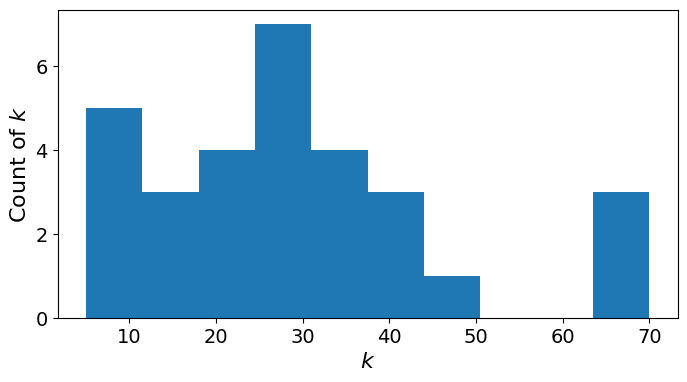

In [ ]:
k = [28, 10, 20, 36, 25, 65, 38, 16, 44, 25, 40, 32, 26, 30, 37, 35, 8, 14, 19, 70, 42, 17, 64, 5, 19, 21, 27, 29, 10, 6]
N = len(k)
# Average
print(sum(k)/N)
plt.figure(figsize=(8, 4))
plt.hist(k)
plt.xlabel('$k$')
plt.ylabel('Count of $k$');

The question the meteorologist asks is straightforward: '__What is the probability of more than 30 days of snowfall in 2021__'?

To answer this question, we first need to find the distribution of days of snowfall in 2021.

Let $k_i$ indicate the number of days of snowfall in year $i$. In Bayesian terms, we need $P(k_{2021} \mid K)$, where we use the shorthand $K=(k_{1991}, \ldots, k_{2020})$ to save ourselves a lot of writing.

$P(k_{2021} \mid K)$ is a __posterior predictive distribution__ (see slides of Lecture 2 for the coin flip equivalent example): it predicts a new observation, based on all observations that came before. Without choosing specific distributions for the likelihood and prior yet, that posterior predictive can be written as:

$$
P(k_{2021} \mid K) =\int P(k_{2021} \mid \lambda) p(\lambda \mid K) \, \mathrm{d}\lambda \enspace,
$$ where $\lambda$ is used as the parameters that we do not know.

As you can see, to find the posterior predictive distribution, we need the posterior $p(\lambda \mid K)$ first. That means we need a prior $p(\lambda)$ and a likelihood $P(k\mid\lambda)$.

(use the material on the lecture slides!)

5. The first question is to select the likelihood $P(k\mid\lambda)$. It should be a distribution that describes the probability of discrete, positive values (the number of days of snowfall cannot be negative, or 3.14; we expect integer values). Furthermore, snowfall is a a pretty rare event. What distribution would be appropriate? What is its parameter?

The poisson distribution is discrete and does not take on negative values.The parameter is lambda for the poisson distribution

6. Whichever distribution you use for the likelihood, it will have one or more parameters. We need to select a distribution that can serve as the prior for each of these. What distribution would be appropriate? Note: different answers are possible. Choosing a conjugate prior is generally a good idea, but since we will be using JAGS, it is not strictly necessary!

The gamma distribution. Gamma is conjugate to the poisson distiribution

The code below is a JAGS template for this question. It is up to you to add the distributions (and potential hyperparameters) you have selected above to this template:

In [ ]:
%%time

jags_model_text = '''
model {
    # prior
    lambda ~ dgamma(alpha, beta)

    # likelihood
    for (i in 1:N) {
      k[i] ~ dpois(lambda)
    }
}
'''

data = dict(k=k, N=N, alpha=1, beta=2)

num_chains = 4
num_iter = 100000

model = pj.Model(jags_model_text, data=data, chains=num_chains)
samples = model.sample(num_iter, vars=['lambda'])

sampling: iterations 400000 of 400000, elapsed 0:00:00, remaining 0:00:00
CPU times: user 150 ms, sys: 969 µs, total: 151 ms
Wall time: 150 ms


7. Make a figure showing the MCMC approximation of the posterior (see first part of this exercise).

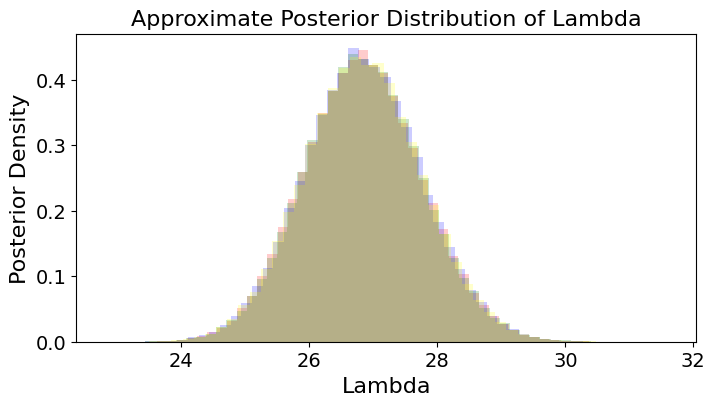

In [ ]:
plt.figure(figsize=(8,4))
lambda_samples = samples['lambda']
for i in range(num_chains):
  plt.hist(lambda_samples[0,:,i], bins=50, color=colors[i], alpha=0.2, density=True)

plt.xlabel('Lambda')
plt.ylabel('Posterior Density')
plt.title('Approximate Posterior Distribution of Lambda')
plt.show()

But we are not done yet! You have now determined the _posterior distribution_ of the unknown parameter of your model. But to answer the question, we need to use this distribution to predict new values for $k$.

8. Copy your JAGS model below and add a line `k2021 ~ d...`. On the $\ldots$, fill in the same likelihood as you did for the `k[i] ~ d...` lines. Note: those `k[i]` are observed, but `k2021` is not observed: we are __predicting__ this value! Now run your model again and make sure PyJAGS tracks both your model parameter as well as the `k2021` variable. Make another figure showing the (normalized) histogram of the prediction.

In [ ]:
%%time

jags_model_text = '''
model {
    # prior
    lambda ~ dgamma(alpha, beta)

    # likelihood
    for (i in 1:N) {
      k[i] ~ dpois(lambda)
    }
    k2021 ~ dpois(lambda)
}
'''
k2021 = []
data = dict(k=k, N=N, alpha=1, beta=2)

num_chains = 4
num_iter = 100000

model = pj.Model(jags_model_text, data=data, chains=num_chains)
samples = model.sample(num_iter, vars=['lambda', 'k2021'])

sampling: iterations 400000 of 400000, elapsed 0:00:00, remaining 0:00:00
CPU times: user 215 ms, sys: 970 µs, total: 216 ms
Wall time: 216 ms


9. So back to the question: what is the probability of

$P(k\geq 30)$? Use the JAGS samples to compute the result.

In [ ]:
samples['k2021'].flatten()
prob = np.mean(samples['k2021'][0,:,i] >= 30)
print("Probability of k >= 30:", prob)

Probability of k >= 30: 0.29637
